# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = layers.Conv2D(filters=filters, kernel_size=(5,5), strides=(1,1) ,
                      padding='same', activation='relu')(input_layer)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    #onebyone_conv_layer = conv2d_batchnorm(x4,512,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    #x4_p = decoder_block(onebyone_conv_layer, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_12/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_14/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_16/batchnorm/add_1:0", s

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0002 # 0.0001 - slow
batch_size = 40 #512/384 => Exhaust resources
num_epochs = 100
num_img_train = 3734
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 94
Validation steps: 30


Epoch 1/100
93/94 [============================>.] - ETA: 1s - loss: 0.9680

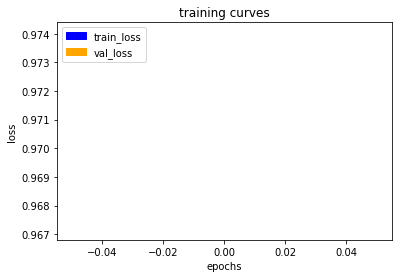

94/94 [==============================] - 189s - loss: 0.9663 - val_loss: 0.9741
Epoch 2/100
93/94 [============================>.] - ETA: 1s - loss: 0.7052

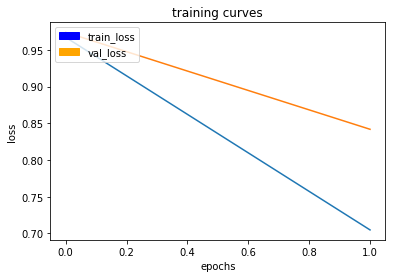

94/94 [==============================] - 188s - loss: 0.7042 - val_loss: 0.8418
Epoch 3/100
93/94 [============================>.] - ETA: 1s - loss: 0.5387

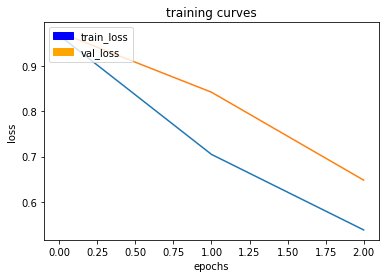

94/94 [==============================] - 188s - loss: 0.5378 - val_loss: 0.6480
Epoch 4/100
93/94 [============================>.] - ETA: 1s - loss: 0.3924

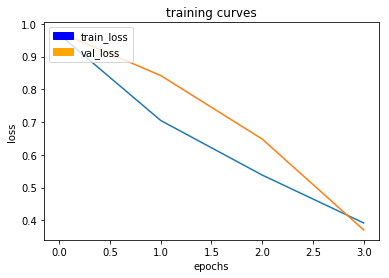

94/94 [==============================] - 188s - loss: 0.3917 - val_loss: 0.3707
Epoch 5/100
93/94 [============================>.] - ETA: 1s - loss: 0.2766

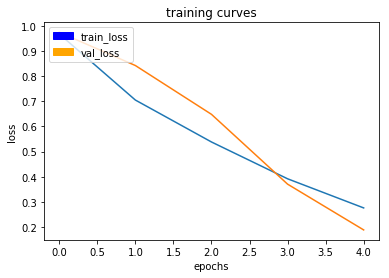

94/94 [==============================] - 188s - loss: 0.2759 - val_loss: 0.1889
Epoch 6/100
93/94 [============================>.] - ETA: 1s - loss: 0.1999

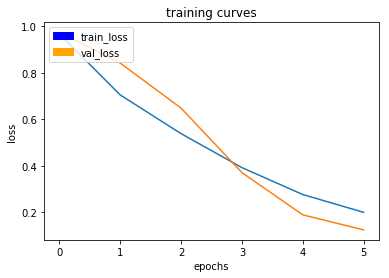

94/94 [==============================] - 187s - loss: 0.1997 - val_loss: 0.1241
Epoch 7/100
93/94 [============================>.] - ETA: 1s - loss: 0.1490

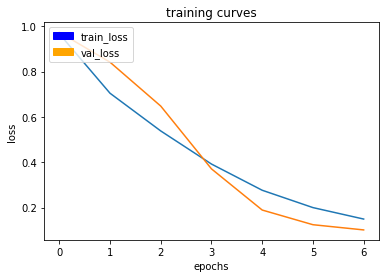

94/94 [==============================] - 188s - loss: 0.1489 - val_loss: 0.1011
Epoch 8/100
93/94 [============================>.] - ETA: 1s - loss: 0.1138

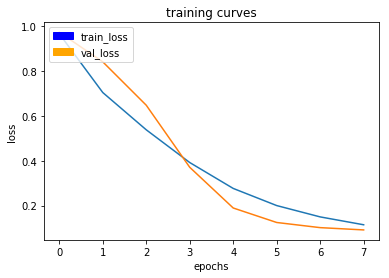

94/94 [==============================] - 188s - loss: 0.1138 - val_loss: 0.0909
Epoch 9/100
93/94 [============================>.] - ETA: 1s - loss: 0.0912

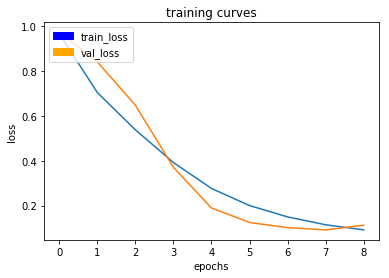

94/94 [==============================] - 188s - loss: 0.0912 - val_loss: 0.1119
Epoch 10/100
93/94 [============================>.] - ETA: 1s - loss: 0.0765

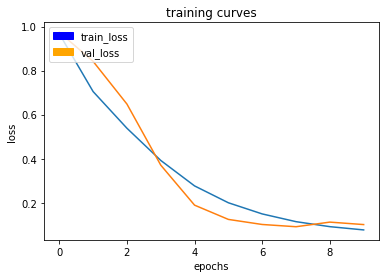

94/94 [==============================] - 188s - loss: 0.0764 - val_loss: 0.1007
Epoch 11/100
93/94 [============================>.] - ETA: 1s - loss: 0.0655

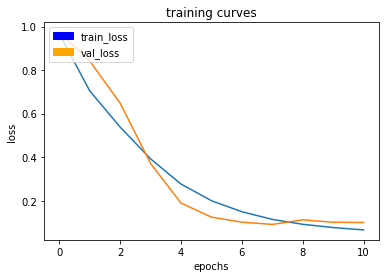

94/94 [==============================] - 187s - loss: 0.0655 - val_loss: 0.0997
Epoch 12/100
93/94 [============================>.] - ETA: 1s - loss: 0.0564

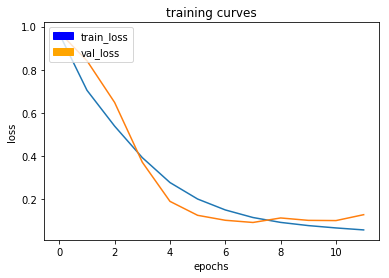

94/94 [==============================] - 187s - loss: 0.0564 - val_loss: 0.1271
Epoch 13/100
93/94 [============================>.] - ETA: 1s - loss: 0.0500

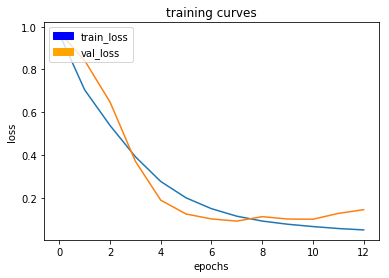

94/94 [==============================] - 187s - loss: 0.0500 - val_loss: 0.1444
Epoch 14/100
93/94 [============================>.] - ETA: 1s - loss: 0.1166

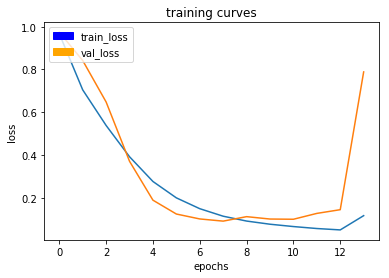

94/94 [==============================] - 188s - loss: 0.1161 - val_loss: 0.7885
Epoch 15/100
93/94 [============================>.] - ETA: 1s - loss: 0.0635

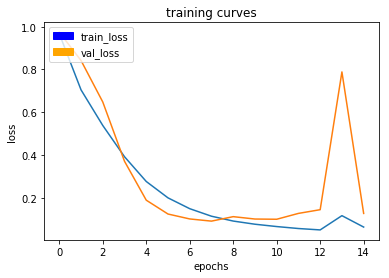

94/94 [==============================] - 187s - loss: 0.0634 - val_loss: 0.1270
Epoch 16/100
93/94 [============================>.] - ETA: 1s - loss: 0.0519

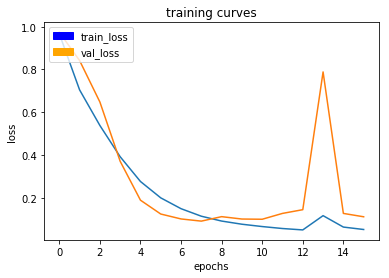

94/94 [==============================] - 187s - loss: 0.0518 - val_loss: 0.1113
Epoch 17/100
93/94 [============================>.] - ETA: 1s - loss: 0.0461

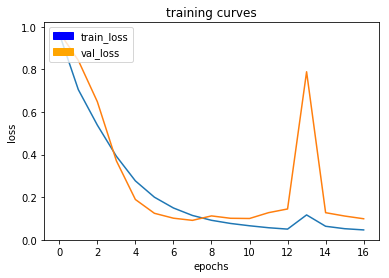

94/94 [==============================] - 188s - loss: 0.0461 - val_loss: 0.0985
Epoch 18/100
93/94 [============================>.] - ETA: 1s - loss: 0.0414

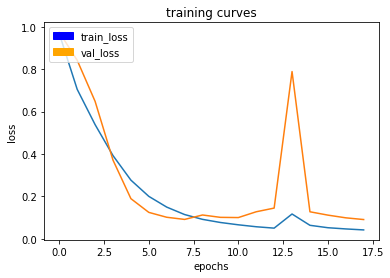

94/94 [==============================] - 187s - loss: 0.0414 - val_loss: 0.0904
Epoch 19/100
93/94 [============================>.] - ETA: 1s - loss: 0.0384

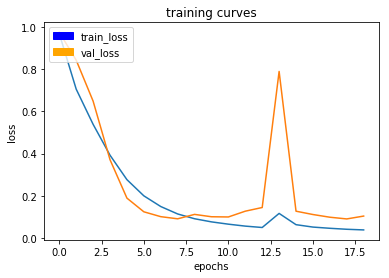

94/94 [==============================] - 188s - loss: 0.0384 - val_loss: 0.1039
Epoch 20/100
93/94 [============================>.] - ETA: 1s - loss: 0.0361

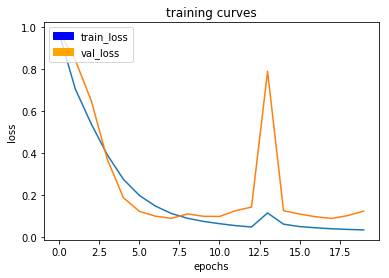

94/94 [==============================] - 187s - loss: 0.0361 - val_loss: 0.1253
Epoch 21/100
93/94 [============================>.] - ETA: 1s - loss: 0.0340

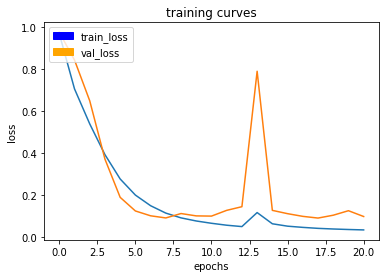

94/94 [==============================] - 188s - loss: 0.0340 - val_loss: 0.0978
Epoch 22/100
93/94 [============================>.] - ETA: 1s - loss: 0.0322

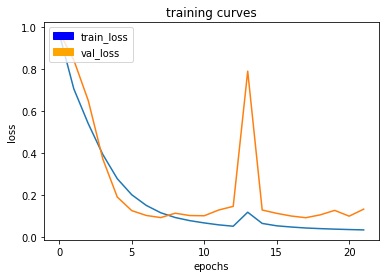

94/94 [==============================] - 188s - loss: 0.0322 - val_loss: 0.1311
Epoch 23/100
93/94 [============================>.] - ETA: 1s - loss: 0.0307

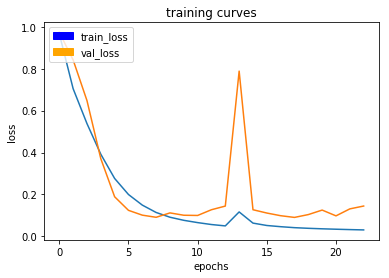

94/94 [==============================] - 187s - loss: 0.0307 - val_loss: 0.1446
Epoch 24/100
93/94 [============================>.] - ETA: 1s - loss: 0.0297

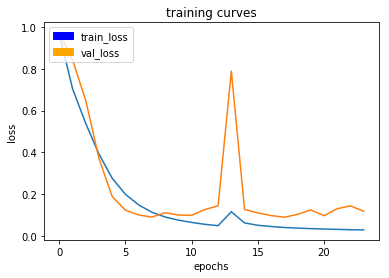

94/94 [==============================] - 188s - loss: 0.0297 - val_loss: 0.1190
Epoch 25/100
93/94 [============================>.] - ETA: 1s - loss: 0.0282

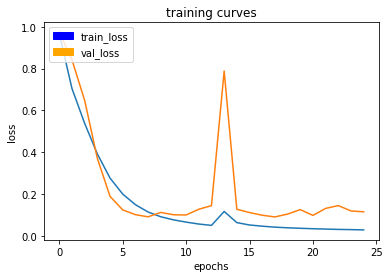

94/94 [==============================] - 187s - loss: 0.0282 - val_loss: 0.1149
Epoch 26/100
93/94 [============================>.] - ETA: 1s - loss: 0.0271

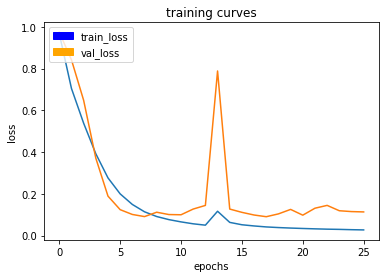

94/94 [==============================] - 188s - loss: 0.0271 - val_loss: 0.1133
Epoch 27/100
93/94 [============================>.] - ETA: 1s - loss: 0.0267

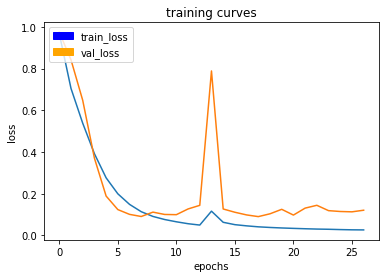

94/94 [==============================] - 187s - loss: 0.0266 - val_loss: 0.1210
Epoch 28/100
93/94 [============================>.] - ETA: 1s - loss: 0.0259

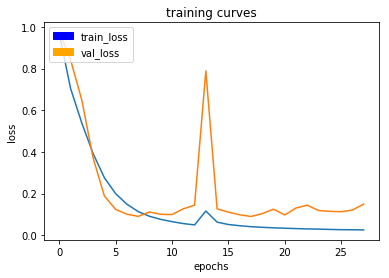

94/94 [==============================] - 188s - loss: 0.0260 - val_loss: 0.1497
Epoch 29/100
93/94 [============================>.] - ETA: 1s - loss: 0.0249

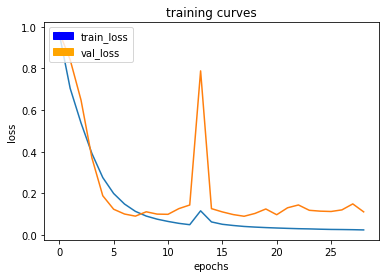

94/94 [==============================] - 187s - loss: 0.0248 - val_loss: 0.1116
Epoch 30/100
93/94 [============================>.] - ETA: 1s - loss: 0.0242

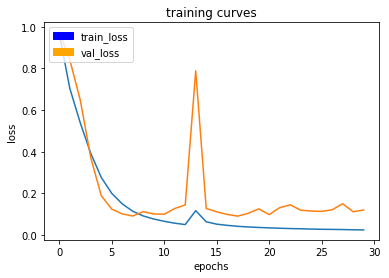

94/94 [==============================] - 187s - loss: 0.0242 - val_loss: 0.1198
Epoch 31/100
93/94 [============================>.] - ETA: 1s - loss: 0.0232

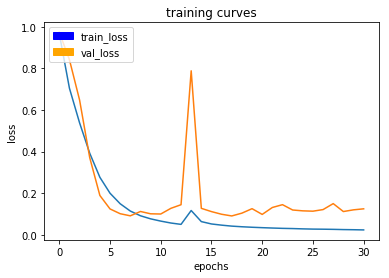

94/94 [==============================] - 187s - loss: 0.0232 - val_loss: 0.1246
Epoch 32/100
93/94 [============================>.] - ETA: 1s - loss: 0.0224

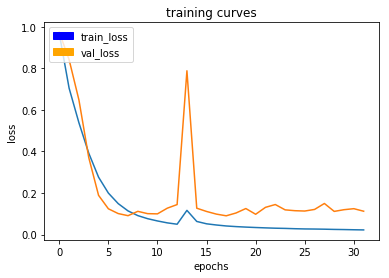

94/94 [==============================] - 187s - loss: 0.0224 - val_loss: 0.1124
Epoch 33/100
93/94 [============================>.] - ETA: 1s - loss: 0.0222

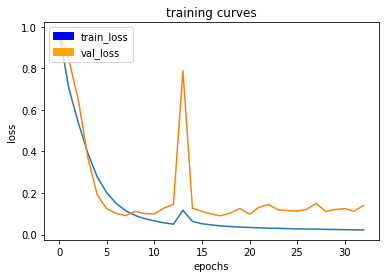

94/94 [==============================] - 188s - loss: 0.0222 - val_loss: 0.1400
Epoch 34/100
93/94 [============================>.] - ETA: 1s - loss: 0.0215

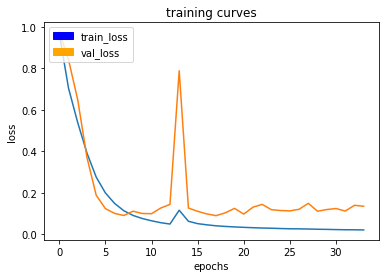

94/94 [==============================] - 187s - loss: 0.0215 - val_loss: 0.1357
Epoch 35/100
93/94 [============================>.] - ETA: 1s - loss: 0.0211

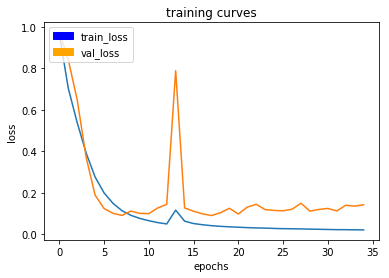

94/94 [==============================] - 187s - loss: 0.0211 - val_loss: 0.1423
Epoch 36/100
93/94 [============================>.] - ETA: 1s - loss: 0.0204

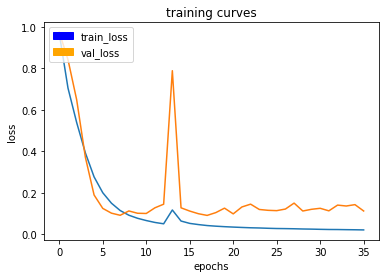

94/94 [==============================] - 187s - loss: 0.0204 - val_loss: 0.1116
Epoch 37/100
93/94 [============================>.] - ETA: 1s - loss: 0.0200

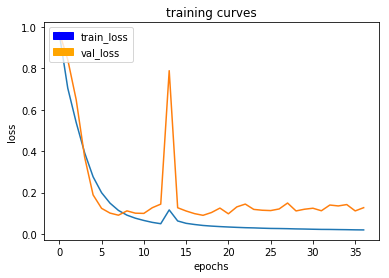

94/94 [==============================] - 188s - loss: 0.0200 - val_loss: 0.1273
Epoch 38/100
93/94 [============================>.] - ETA: 1s - loss: 0.0197

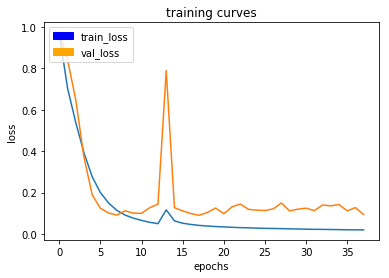

94/94 [==============================] - 187s - loss: 0.0197 - val_loss: 0.0941
Epoch 39/100
93/94 [============================>.] - ETA: 1s - loss: 0.0192

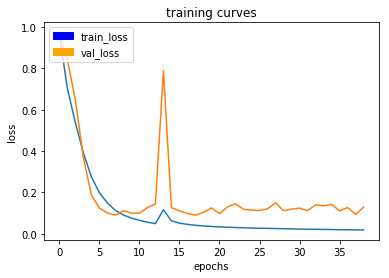

94/94 [==============================] - 187s - loss: 0.0192 - val_loss: 0.1297
Epoch 40/100
93/94 [============================>.] - ETA: 1s - loss: 0.0186

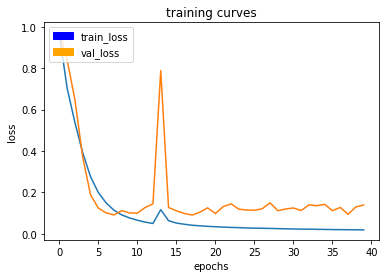

94/94 [==============================] - 187s - loss: 0.0186 - val_loss: 0.1388
Epoch 41/100
93/94 [============================>.] - ETA: 1s - loss: 0.0182

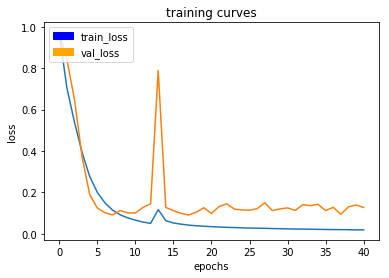

94/94 [==============================] - 187s - loss: 0.0183 - val_loss: 0.1271
Epoch 42/100
93/94 [============================>.] - ETA: 1s - loss: 0.0179

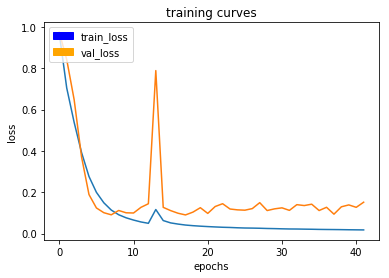

94/94 [==============================] - 188s - loss: 0.0179 - val_loss: 0.1519
Epoch 43/100
93/94 [============================>.] - ETA: 1s - loss: 0.0176

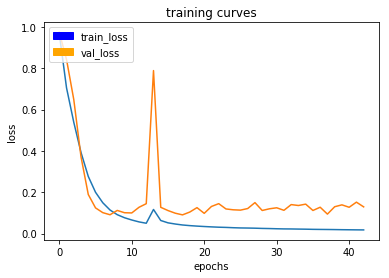

94/94 [==============================] - 188s - loss: 0.0176 - val_loss: 0.1291
Epoch 44/100
93/94 [============================>.] - ETA: 1s - loss: 0.0170

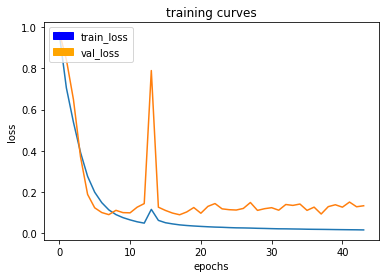

94/94 [==============================] - 187s - loss: 0.0170 - val_loss: 0.1340
Epoch 45/100
93/94 [============================>.] - ETA: 1s - loss: 0.0168

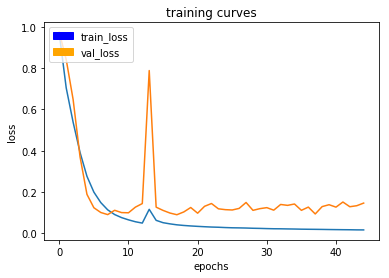

94/94 [==============================] - 187s - loss: 0.0168 - val_loss: 0.1467
Epoch 46/100
93/94 [============================>.] - ETA: 1s - loss: 0.0166

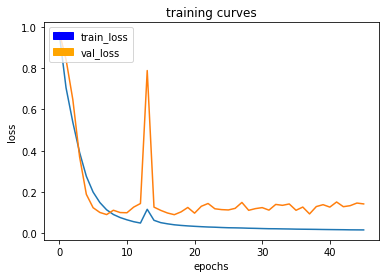

94/94 [==============================] - 188s - loss: 0.0166 - val_loss: 0.1425
Epoch 47/100
93/94 [============================>.] - ETA: 1s - loss: 0.0164

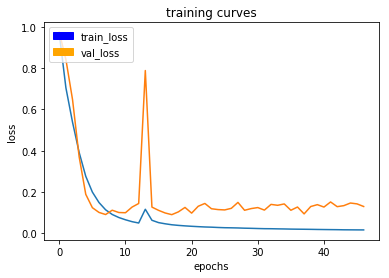

94/94 [==============================] - 188s - loss: 0.0164 - val_loss: 0.1299
Epoch 48/100
93/94 [============================>.] - ETA: 1s - loss: 0.0160

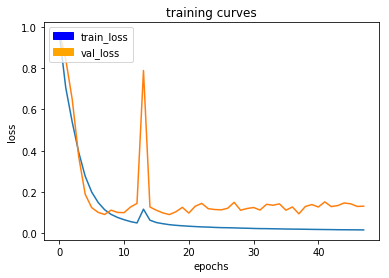

94/94 [==============================] - 188s - loss: 0.0161 - val_loss: 0.1310
Epoch 49/100
93/94 [============================>.] - ETA: 1s - loss: 0.0157

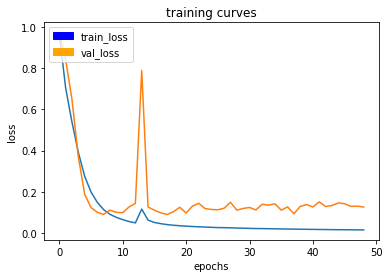

94/94 [==============================] - 188s - loss: 0.0157 - val_loss: 0.1265
Epoch 50/100
93/94 [============================>.] - ETA: 1s - loss: 0.0156

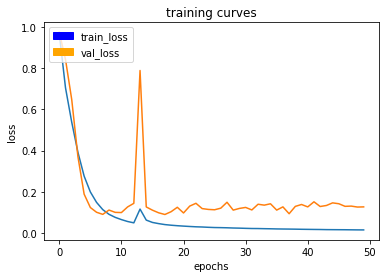

94/94 [==============================] - 188s - loss: 0.0156 - val_loss: 0.1272
Epoch 51/100
93/94 [============================>.] - ETA: 1s - loss: 0.0154

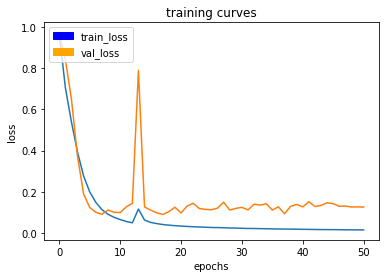

94/94 [==============================] - 188s - loss: 0.0154 - val_loss: 0.1260
Epoch 52/100
93/94 [============================>.] - ETA: 1s - loss: 0.0150

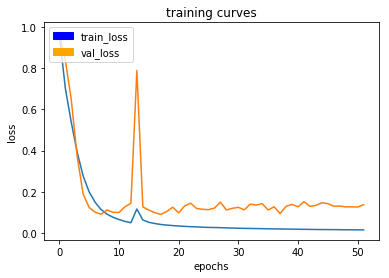

94/94 [==============================] - 187s - loss: 0.0150 - val_loss: 0.1374
Epoch 53/100
93/94 [============================>.] - ETA: 1s - loss: 0.0147

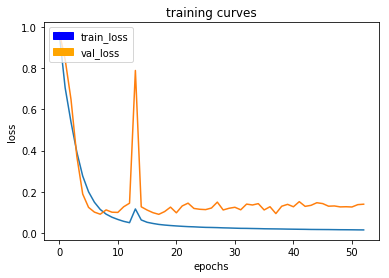

94/94 [==============================] - 188s - loss: 0.0147 - val_loss: 0.1395
Epoch 54/100
93/94 [============================>.] - ETA: 1s - loss: 0.0144

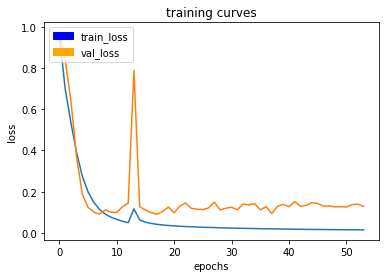

94/94 [==============================] - 188s - loss: 0.0144 - val_loss: 0.1285
Epoch 55/100
93/94 [============================>.] - ETA: 1s - loss: 0.0142

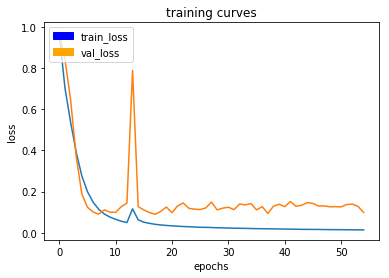

94/94 [==============================] - 188s - loss: 0.0142 - val_loss: 0.0989
Epoch 56/100
93/94 [============================>.] - ETA: 1s - loss: 0.0139

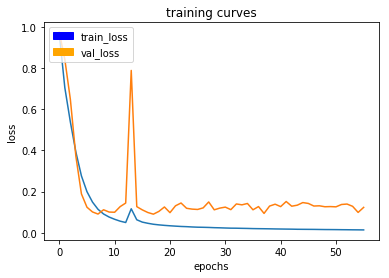

94/94 [==============================] - 187s - loss: 0.0139 - val_loss: 0.1233
Epoch 57/100
93/94 [============================>.] - ETA: 1s - loss: 0.0138

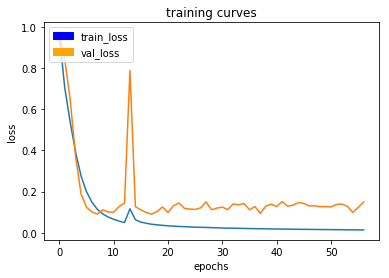

94/94 [==============================] - 187s - loss: 0.0138 - val_loss: 0.1496
Epoch 58/100
93/94 [============================>.] - ETA: 1s - loss: 0.0137

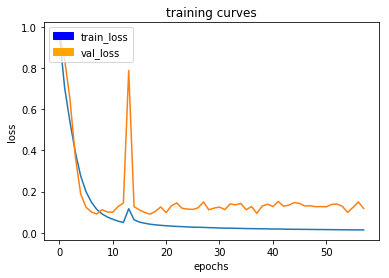

94/94 [==============================] - 187s - loss: 0.0137 - val_loss: 0.1181
Epoch 59/100
93/94 [============================>.] - ETA: 1s - loss: 0.0136

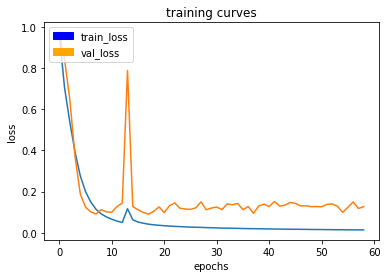

94/94 [==============================] - 188s - loss: 0.0136 - val_loss: 0.1265
Epoch 60/100
93/94 [============================>.] - ETA: 1s - loss: 0.0133

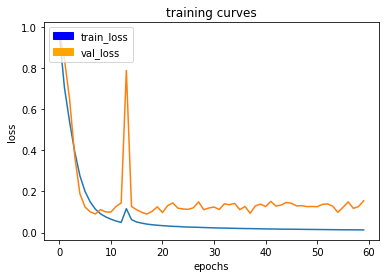

94/94 [==============================] - 188s - loss: 0.0133 - val_loss: 0.1549
Epoch 61/100
93/94 [============================>.] - ETA: 1s - loss: 0.0131

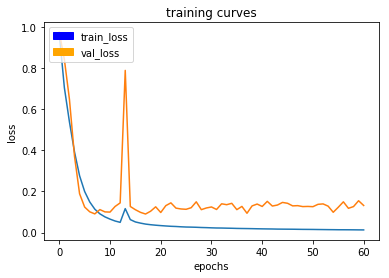

94/94 [==============================] - 188s - loss: 0.0131 - val_loss: 0.1319
Epoch 62/100
93/94 [============================>.] - ETA: 1s - loss: 0.0129

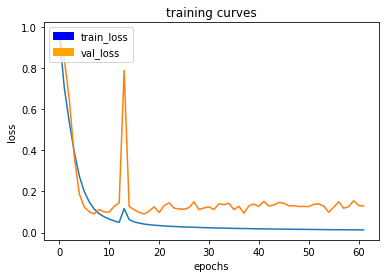

94/94 [==============================] - 187s - loss: 0.0129 - val_loss: 0.1292
Epoch 63/100
93/94 [============================>.] - ETA: 1s - loss: 0.0127

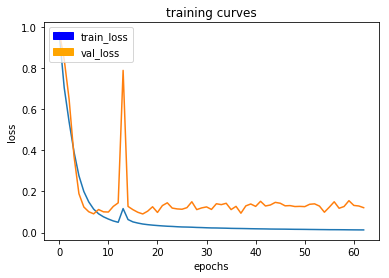

94/94 [==============================] - 189s - loss: 0.0128 - val_loss: 0.1209
Epoch 64/100
93/94 [============================>.] - ETA: 1s - loss: 0.0124

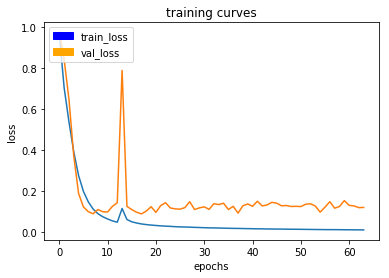

94/94 [==============================] - 187s - loss: 0.0124 - val_loss: 0.1217
Epoch 65/100
93/94 [============================>.] - ETA: 1s - loss: 0.0123

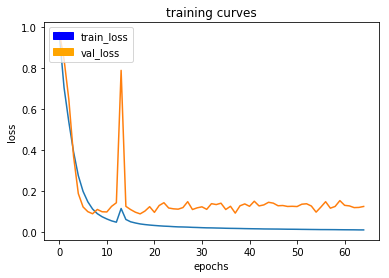

94/94 [==============================] - 188s - loss: 0.0123 - val_loss: 0.1264
Epoch 66/100
93/94 [============================>.] - ETA: 1s - loss: 0.0122

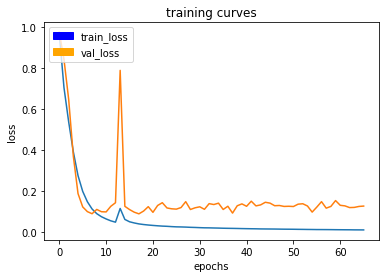

94/94 [==============================] - 187s - loss: 0.0122 - val_loss: 0.1281
Epoch 67/100
93/94 [============================>.] - ETA: 1s - loss: 0.0120

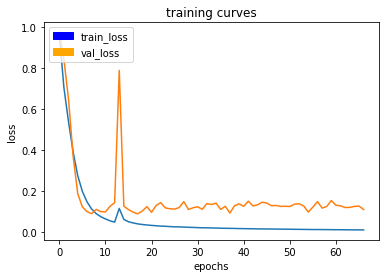

94/94 [==============================] - 187s - loss: 0.0120 - val_loss: 0.1112
Epoch 68/100
93/94 [============================>.] - ETA: 1s - loss: 0.0119

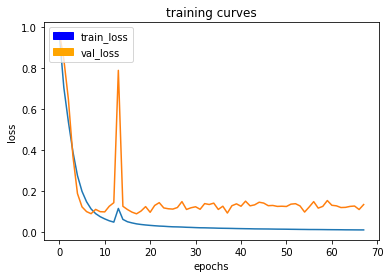

94/94 [==============================] - 187s - loss: 0.0119 - val_loss: 0.1354
Epoch 69/100
93/94 [============================>.] - ETA: 1s - loss: 0.0141

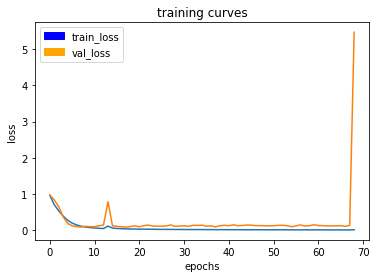

94/94 [==============================] - 188s - loss: 0.0150 - val_loss: 5.4606
Epoch 70/100
93/94 [============================>.] - ETA: 1s - loss: 0.0293

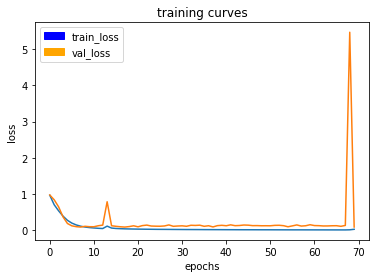

94/94 [==============================] - 188s - loss: 0.0292 - val_loss: 0.0915
Epoch 71/100
93/94 [============================>.] - ETA: 1s - loss: 0.0204

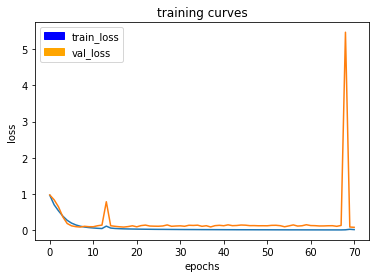

94/94 [==============================] - 188s - loss: 0.0204 - val_loss: 0.0836
Epoch 72/100
93/94 [============================>.] - ETA: 1s - loss: 0.0181

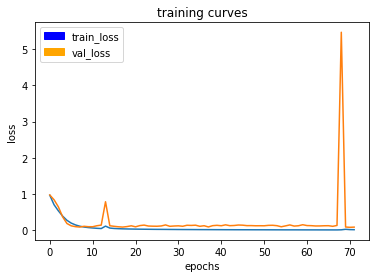

94/94 [==============================] - 187s - loss: 0.0181 - val_loss: 0.0888
Epoch 73/100
93/94 [============================>.] - ETA: 1s - loss: 0.0171

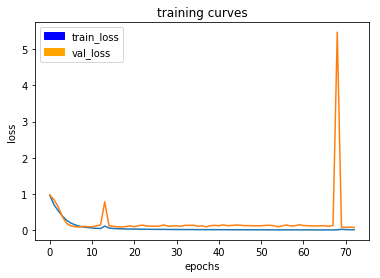

94/94 [==============================] - 187s - loss: 0.0171 - val_loss: 0.0790
Epoch 74/100
93/94 [============================>.] - ETA: 1s - loss: 0.0162

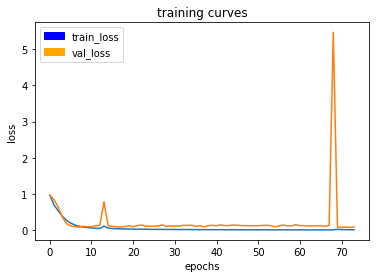

94/94 [==============================] - 188s - loss: 0.0162 - val_loss: 0.0964
Epoch 75/100
93/94 [============================>.] - ETA: 1s - loss: 0.0156

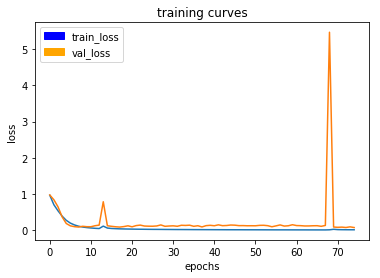

94/94 [==============================] - 188s - loss: 0.0156 - val_loss: 0.0777
Epoch 76/100
93/94 [============================>.] - ETA: 1s - loss: 0.0152

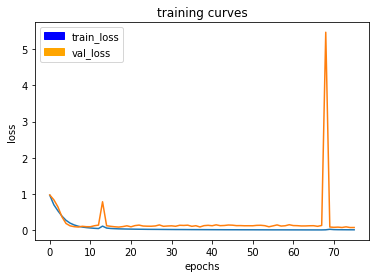

94/94 [==============================] - 188s - loss: 0.0152 - val_loss: 0.0785
Epoch 77/100
93/94 [============================>.] - ETA: 1s - loss: 0.0147

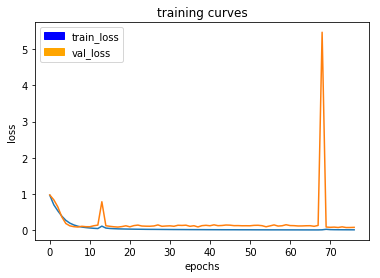

94/94 [==============================] - 188s - loss: 0.0147 - val_loss: 0.0826
Epoch 78/100
93/94 [============================>.] - ETA: 1s - loss: 0.0144

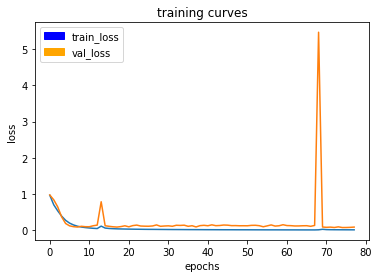

94/94 [==============================] - 187s - loss: 0.0144 - val_loss: 0.0897
Epoch 79/100
93/94 [============================>.] - ETA: 1s - loss: 0.0141

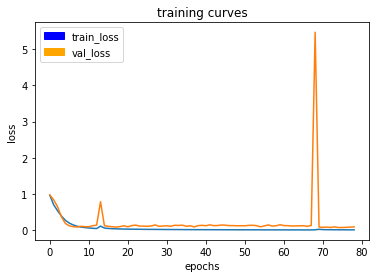

94/94 [==============================] - 188s - loss: 0.0141 - val_loss: 0.0944
Epoch 80/100
93/94 [============================>.] - ETA: 1s - loss: 0.0137

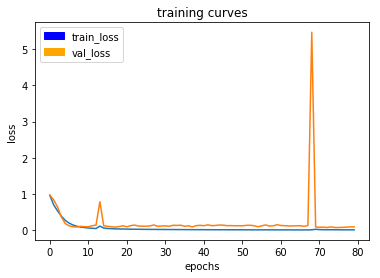

94/94 [==============================] - 188s - loss: 0.0137 - val_loss: 0.0981
Epoch 81/100
93/94 [============================>.] - ETA: 1s - loss: 0.0134

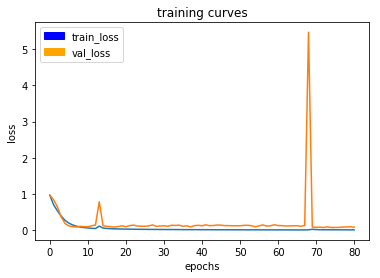

94/94 [==============================] - 188s - loss: 0.0134 - val_loss: 0.0887
Epoch 82/100
93/94 [============================>.] - ETA: 1s - loss: 0.0133

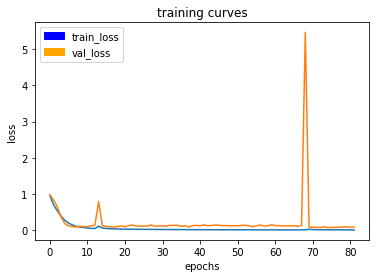

94/94 [==============================] - 187s - loss: 0.0133 - val_loss: 0.0901
Epoch 83/100
93/94 [============================>.] - ETA: 1s - loss: 0.0128

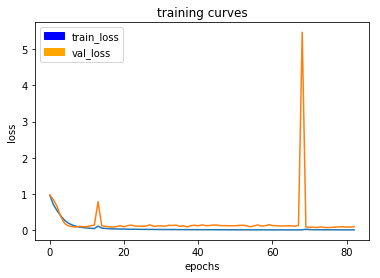

94/94 [==============================] - 188s - loss: 0.0128 - val_loss: 0.1011
Epoch 84/100
93/94 [============================>.] - ETA: 1s - loss: 0.0125

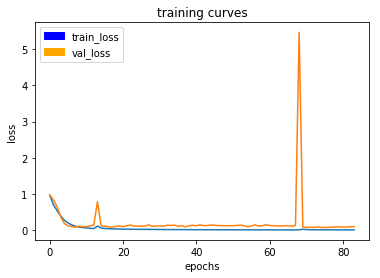

94/94 [==============================] - 188s - loss: 0.0125 - val_loss: 0.1008
Epoch 85/100
93/94 [============================>.] - ETA: 1s - loss: 0.0124

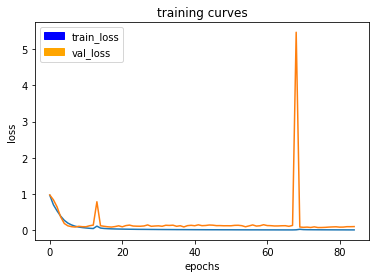

94/94 [==============================] - 187s - loss: 0.0124 - val_loss: 0.1036
Epoch 86/100
93/94 [============================>.] - ETA: 1s - loss: 0.0121

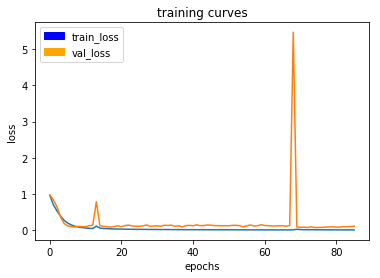

94/94 [==============================] - 188s - loss: 0.0121 - val_loss: 0.1166
Epoch 87/100
93/94 [============================>.] - ETA: 1s - loss: 0.0119

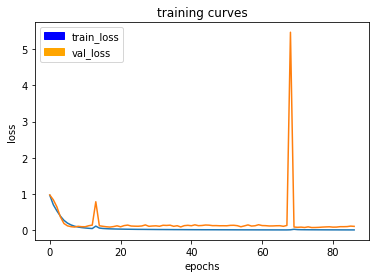

94/94 [==============================] - 188s - loss: 0.0119 - val_loss: 0.1098
Epoch 88/100
93/94 [============================>.] - ETA: 1s - loss: 0.0119

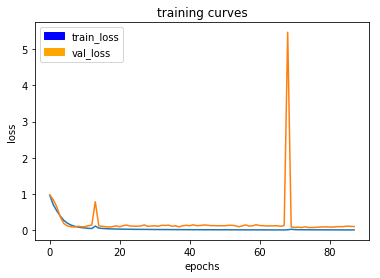

94/94 [==============================] - 188s - loss: 0.0119 - val_loss: 0.1045
Epoch 89/100
93/94 [============================>.] - ETA: 1s - loss: 0.0117

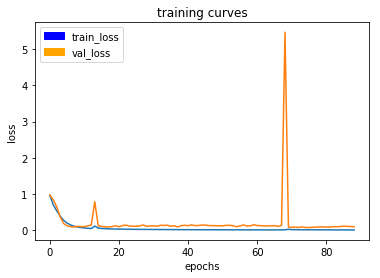

94/94 [==============================] - 188s - loss: 0.0117 - val_loss: 0.0991
Epoch 90/100
93/94 [============================>.] - ETA: 1s - loss: 0.0114

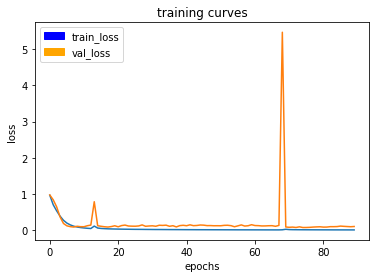

94/94 [==============================] - 188s - loss: 0.0114 - val_loss: 0.1055
Epoch 91/100
93/94 [============================>.] - ETA: 1s - loss: 0.0112

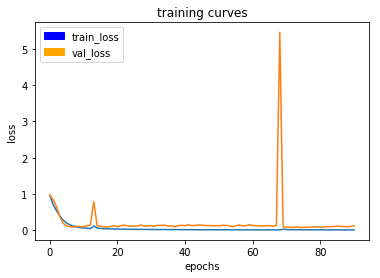

94/94 [==============================] - 188s - loss: 0.0112 - val_loss: 0.1279
Epoch 92/100
93/94 [============================>.] - ETA: 1s - loss: 0.0111

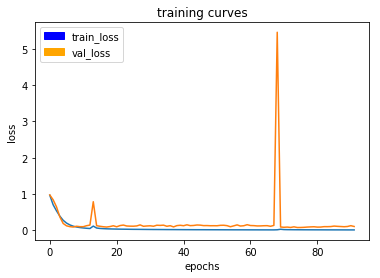

94/94 [==============================] - 187s - loss: 0.0111 - val_loss: 0.1055
Epoch 93/100
93/94 [============================>.] - ETA: 1s - loss: 0.0108

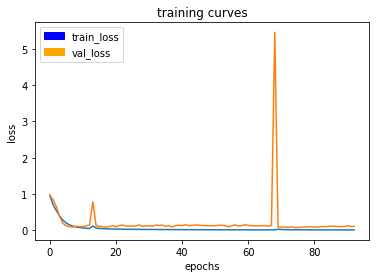

94/94 [==============================] - 188s - loss: 0.0108 - val_loss: 0.1079
Epoch 94/100
93/94 [============================>.] - ETA: 1s - loss: 0.0107

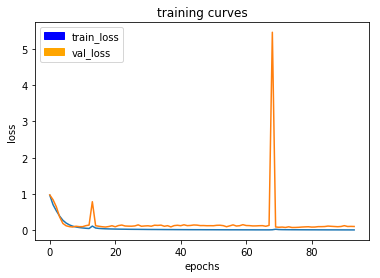

94/94 [==============================] - 188s - loss: 0.0107 - val_loss: 0.1052
Epoch 95/100
93/94 [============================>.] - ETA: 1s - loss: 0.0106

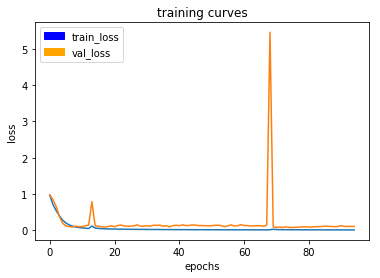

94/94 [==============================] - 188s - loss: 0.0106 - val_loss: 0.1072
Epoch 96/100
93/94 [============================>.] - ETA: 1s - loss: 0.0105

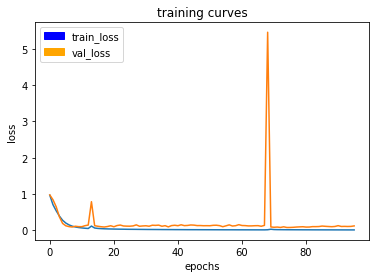

94/94 [==============================] - 188s - loss: 0.0105 - val_loss: 0.1210
Epoch 97/100
93/94 [============================>.] - ETA: 1s - loss: 0.0103

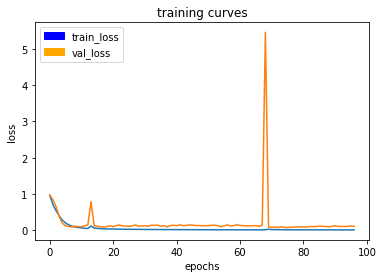

94/94 [==============================] - 188s - loss: 0.0103 - val_loss: 0.1100
Epoch 98/100
93/94 [============================>.] - ETA: 1s - loss: 0.0109

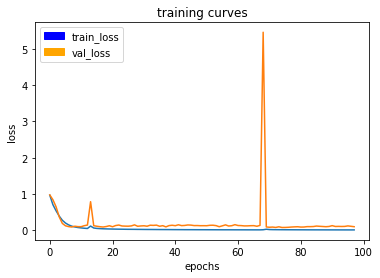

94/94 [==============================] - 187s - loss: 0.0109 - val_loss: 0.0989
Epoch 99/100
93/94 [============================>.] - ETA: 1s - loss: 0.0107

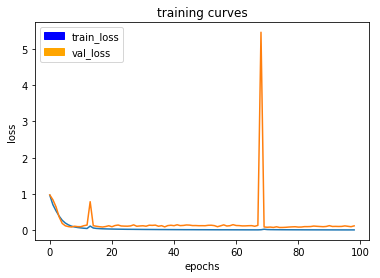

94/94 [==============================] - 188s - loss: 0.0107 - val_loss: 0.1220
Epoch 100/100
93/94 [============================>.] - ETA: 1s - loss: 0.0102

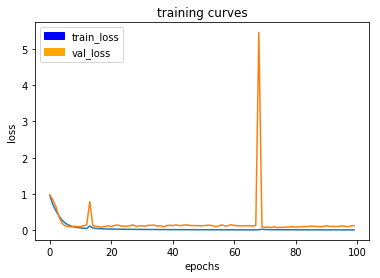

94/94 [==============================] - 188s - loss: 0.0102 - val_loss: 0.1286


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [18]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

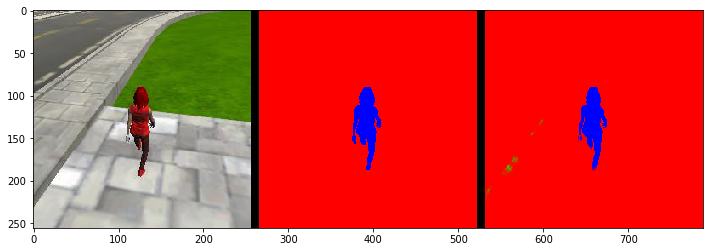

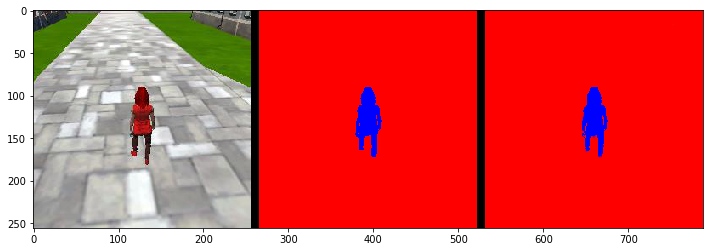

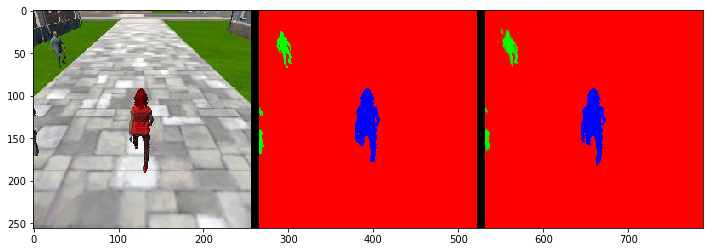

In [12]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

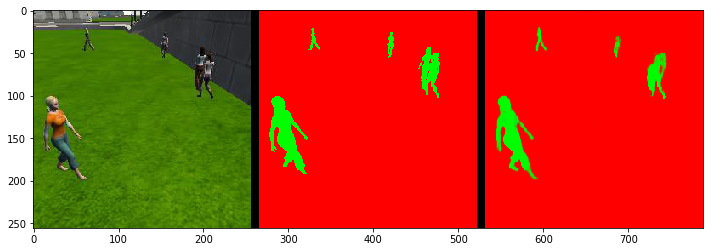

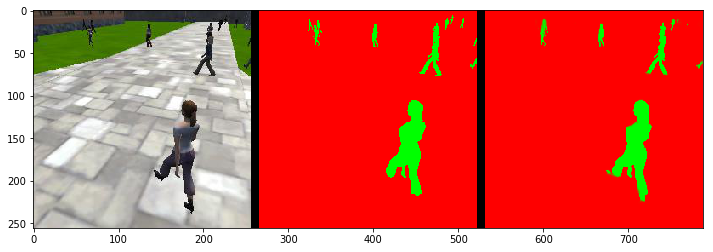

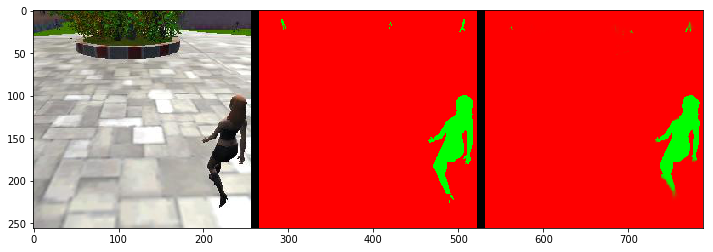

In [21]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

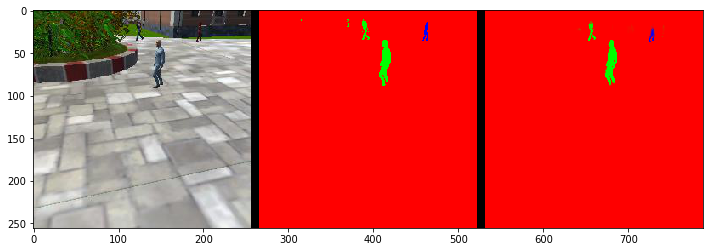

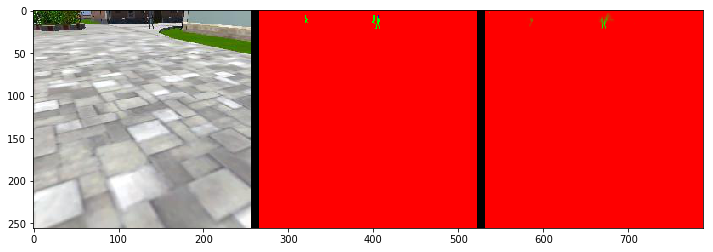

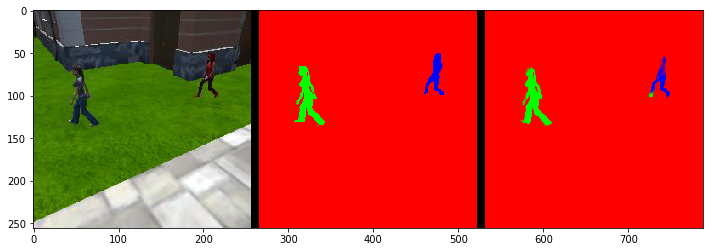

In [13]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [14]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9960525269750348
average intersection over union for other people is 0.31254731752960396
average intersection over union for the hero is 0.9521549169366098
number true positives: 539, number false positives: 0, number false negatives: 0


In [15]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9895137615558838
average intersection over union for other people is 0.7866044861319259
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 70, number false negatives: 0


In [16]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9972704869401463
average intersection over union for other people is 0.4717688129466053
average intersection over union for the hero is 0.41709093732249897
number true positives: 190, number false positives: 3, number false negatives: 122


In [17]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.788961038961039


In [18]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.68462292713


In [19]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.540140815885
